In [62]:
import sys
sys.path.append('../../')
import operator
import json
import os
import numpy as np
from utils import utils
json_file = "../../gtex_v8_metadata.json"
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/main/tissues.txt"
tissue_file = "/usr/users/fsimone/trans-eqtl-pipeline/analysis/plots/tissue_table.txt"
tshorts, tfulls_plain = utils.read_tissues(tissue_file, plain=True)
_, tfulls = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors  = dict()
tissue_names   = dict()
tissue_samples = dict()
for tshort, tfull in zip(tshorts, tfulls_plain):
    tissue_names[tshort] = tfull
for tshort, tfull in zip(tshorts, tfulls):
    tissue_colors[tshort] = "#" + gtex_meta[tfull.replace(" ", "_")]["colorHex"]
    tissue_samples[tshort] = gtex_meta[tfull.replace(" ", "_")]["rnaSeqAndGenotypeSampleCount"]


In [87]:
import collections 
import re
import copy

DHSINFO_FIELDS = ['tissue', 'neqtl', 'ndhs', 'enrichment', 'pval']
class DhsInfo(collections.namedtuple('_DhsInfo', DHSINFO_FIELDS)):
    __slots__ = ()

def read_enrichments(filepath):
    res = dict()
    with open(filepath) as instream:
        for line in instream:
            if re.match("tissue", line):
                continue
            arr = line.strip().split("\t")
            tissue = arr[0]
            neqtl = int(arr[3])
            ndhs  = int(arr[4])
            enrich = float(arr[5])
            enrichment = np.log2(enrich) if enrich > 0 else 0.0
            pval = float(arr[6])
            if ndhs > 5:
                res[tissue] = DhsInfo(tissue=tissue, neqtl=neqtl, ndhs=ndhs, enrichment=enrichment, pval=pval)
            else:
                res[tissue] = DhsInfo(tissue=tissue, neqtl=neqtl, ndhs=ndhs, enrichment=0.0, pval=1.0)
    return res

def read_enrichments_new(filepath):
    res = dict()
    with open(filepath) as instream:
        for line in instream:
            if re.match("tissue", line):
                continue
            arr = line.strip().split("\t")
            tissue = arr[0]
            neqtl = int(arr[2])
            ndhs  = int(arr[3])
            enrich = float(arr[4])
            enrichment = np.log2(enrich) if enrich > 0 else 0.0
            pval = float(arr[5])
            if ndhs > 5:
                res[tissue] = DhsInfo(tissue=tissue, neqtl=neqtl, ndhs=ndhs, enrichment=enrichment, pval=pval)
            else:
                res[tissue] = DhsInfo(tissue=tissue, neqtl=neqtl, ndhs=ndhs, enrichment=0.0, pval=1.0)
    return res

def read_enrichments_new_less(filepath):
    res = dict()
    with open(filepath) as instream:
        for line in instream:
            if re.match("tissue", line):
                continue
            arr = line.strip().split("\t")
            tissue = arr[0]
            neqtl = int(arr[1])
            ndhs  = int(arr[2])
            enrich = float(arr[3])
            enrichment = np.log2(enrich) if enrich > 0 else 0.0
            pval = float(arr[4])
            if ndhs > 5:
                res[tissue] = DhsInfo(tissue=tissue, neqtl=neqtl, ndhs=ndhs, enrichment=enrichment, pval=pval)
            else:
                res[tissue] = DhsInfo(tissue=tissue, neqtl=neqtl, ndhs=ndhs, enrichment=0.0, pval=1.0)
    return res

basedir = "/cbscratch/franco/trans-eqtl/dev-pipeline/"
path1 = basedir+"gtex_v8_pub_lncRNA/raw/summary_5e-08/dhs_enrichments/permnull_sb0.1_knn30_crossmap"
path2 = basedir+"gtex_v8_lncRNA_freeze/raw/summary_5e-08/dhs_enrichments/permnull_sb0.1_knn30"
path3 = basedir+"gtex_v8_pub_lncRNA_nogtknn/raw/summary_5e-08/dhs_enrichments/permnull_sb0.1_knn30_crossmap_nogtknn"
path4 = basedir+"gtex_v8_pub_lncRNA_nogtknn/raw/summary_5e-08/dhs_enrichments/permnull_sb0.1_knn30_nogtknn"
path5 = basedir+"gtex_v8_pub_lncRNA/raw_pub/summary_5e-08/dhs_enrichments/permnull_sb0.1_knn30_crossmap"
path6 = basedir+"gtex_v8_SHAPEIT2/raw_wasp/summary_5e-08/dhs_enrichments/permnull_sb0.1_knn30"

path7 = "/cbscratch/franco/trans-eqtl/protein_coding_lncRNA_gamma01_knn30_cut5e-8/dhs_enrichments/dhs_enrichment_multi_tissue_pc_lncRNA_gamma01_knn30_cut5e-8_ldpruned.txt"
path8 = basedir+"gtex_v8_SHAPEIT2/raw_pub/summary_5e-08/dhs_enrichments/permnull_sb0.1_knn30_crossmap"

target_file = "dhs_enrichment_multi_tissue_5e-08.txt.ld_prune"

res_ph_cm = read_enrichments(os.path.join(path1, target_file)) 
res_ph = read_enrichments(os.path.join(path2, target_file)) 
res_ph_cm_nogtknn = read_enrichments(os.path.join(path3, target_file)) 
res_ph_nogtknn = read_enrichments(os.path.join(path4, target_file))
res_pub_cm = read_enrichments(os.path.join(path5, target_file))

res_wasp = read_enrichments(os.path.join(path6, target_file))
res_sh2 = read_enrichments_new(os.path.join(path7))  # uses saikat's format
res_sh2_pub_cm = read_enrichments_new_less(os.path.join(path8, target_file))


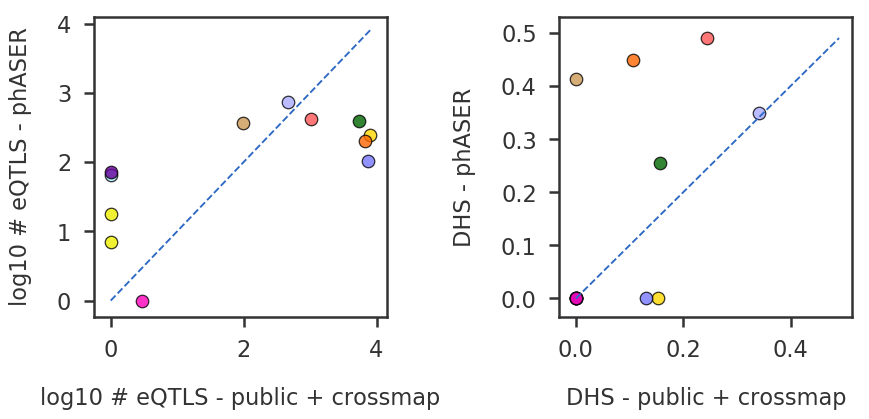

In [101]:
import matplotlib.pyplot as plt
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 90)

res1 = copy.copy(res_pub_cm)
res2 = copy.copy(res_ph)
neqtl1 = []
neqtl2 = []
ts_indata = list()
for ts in tshorts:
    if ts not in res1 and ts not in res2:
        print(f"{ts} not in dataset")
        continue
    else:
        neqtl1.append(np.log10(res1[ts].neqtl) if ts in res1 else 0)
        neqtl2.append(np.log10(res2[ts].neqtl) if ts in res2 else 0)
        ts_indata.append(ts)

enrich1 = []  # crossmap phaser
enrich2 = []  # regular  phaser
ts_color = dict()
ed_color = dict()
ts_alpha = dict()
pval_c = 0.05
for ts in ts_indata:
    ts_color[ts] = tissue_colors[ts]
    ts_alpha[ts] = 0.9
    ed_color[ts] = "face"
    enrich1.append(res1[ts].enrichment if ts in res1 and res1[ts].pval < pval_c else 0)
    enrich2.append(res2[ts].enrichment if ts in res2 and res2[ts].pval < pval_c else 0)
    
fig = plt.figure(figsize=(10,5))
ax1 = fig.add_subplot(121)
for i, ts in enumerate(ts_indata):
    ax1.scatter(neqtl1[i], neqtl2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax1.plot([0,max(neqtl1+ neqtl2)],[0,max(neqtl1+ neqtl2)], linestyle="--")
ax1.set_xlabel("log10 # eQTLS - public + crossmap")
ax1.set_ylabel("log10 # eQTLS - phASER")


ax2 = fig.add_subplot(122)
for i, ts in enumerate(ts_indata):
    ax2.scatter(enrich1[i], enrich2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax2.plot([0,max(enrich1+enrich2)],[0,max(enrich1+enrich2)], linestyle="--")
ax2.set_xlabel("DHS - public + crossmap")
ax2.set_ylabel("DHS - phASER")


plt.tight_layout()
plt.show()


wb not in dataset


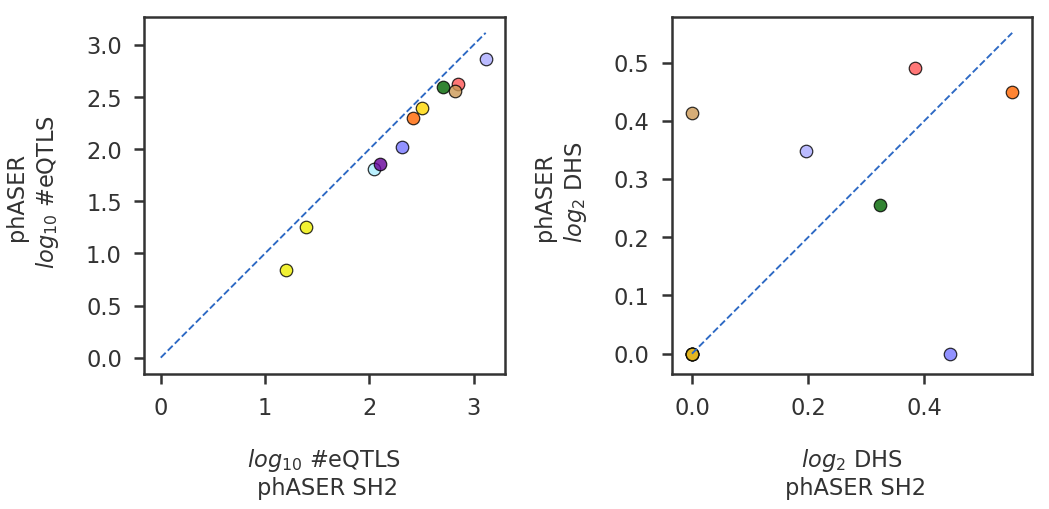

In [119]:
res1 = copy.copy(res_sh2)
res2 = copy.copy(res_ph)
neqtl1 = []
neqtl2 = []
ts_indata = list()
for ts in tshorts:
    if ts not in res1 and ts not in res2:
        print(f"{ts} not in dataset")
        continue
    else:
        neqtl1.append(np.log10(res1[ts].neqtl) if ts in res1 else 0)
        neqtl2.append(np.log10(res2[ts].neqtl) if ts in res2 else 0)
        ts_indata.append(ts)

enrich1 = []  # crossmap phaser
enrich2 = []  # regular  phaser
ts_color = dict()
ed_color = dict()
ts_alpha = dict()
pval_c = 0.05
for ts in ts_indata:
    ts_color[ts] = tissue_colors[ts]
    ts_alpha[ts] = 0.9
    ed_color[ts] = "face"
    enrich1.append(res1[ts].enrichment if ts in res1 and res1[ts].pval < pval_c else 0)
    enrich2.append(res2[ts].enrichment if ts in res2 and res2[ts].pval < pval_c else 0)
    
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
for i, ts in enumerate(ts_indata):
    ax1.scatter(neqtl1[i], neqtl2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax1.plot([0,max(neqtl1+ neqtl2)],[0,max(neqtl1+ neqtl2)], linestyle="--")
ax1.set_xlabel("$log_{10}$ #eQTLS \n phASER SH2")
ax1.set_ylabel("phASER \n $log_{10}$ #eQTLS")


ax2 = fig.add_subplot(122)
for i, ts in enumerate(ts_indata):
    ax2.scatter(enrich1[i], enrich2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax2.plot([0,max(enrich1+enrich2)],[0,max(enrich1+enrich2)], linestyle="--")
ax2.set_xlabel("$log_2$ DHS \n phASER SH2")
ax2.set_ylabel("phASER \n $log_2$ DHS")


plt.tight_layout()
plt.show()


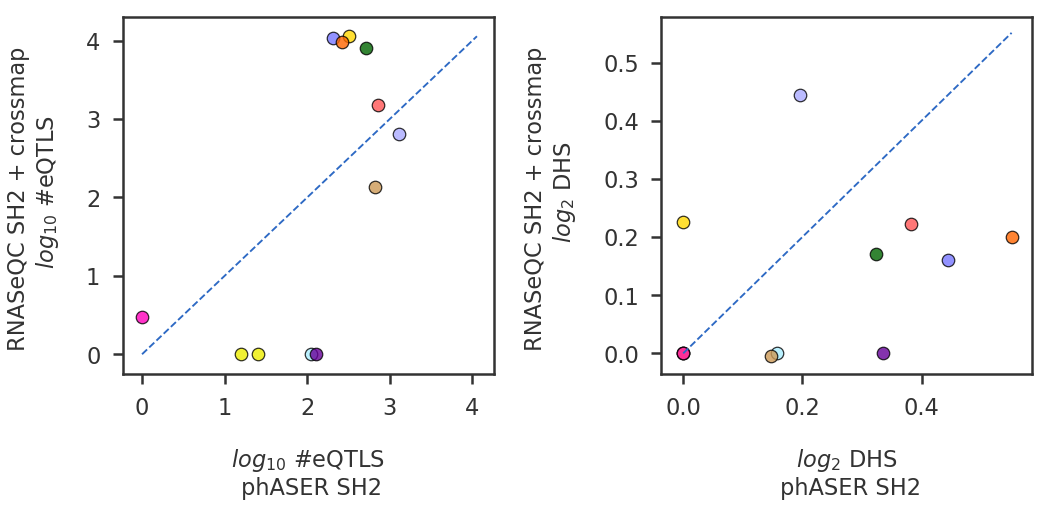

In [120]:
res1 = copy.copy(res_sh2)
res2 = copy.copy(res_sh2_pub_cm)
neqtl1 = []
neqtl2 = []
ts_indata = list()
for ts in tshorts:
    if ts not in res1 and ts not in res2:
        print(f"{ts} not in dataset")
        continue
    else:
        neqtl1.append(np.log10(res1[ts].neqtl) if ts in res1 else 0)
        neqtl2.append(np.log10(res2[ts].neqtl) if ts in res2 else 0)
        ts_indata.append(ts)

enrich1 = []  # crossmap phaser
enrich2 = []  # regular  phaser
ts_color = dict()
ed_color = dict()
ts_alpha = dict()
pval_c = 1
for ts in ts_indata:
    ts_color[ts] = tissue_colors[ts]
    ts_alpha[ts] = 0.9
    ed_color[ts] = "face"
    enrich1.append(res1[ts].enrichment if ts in res1 and res1[ts].pval < pval_c else 0)
    enrich2.append(res2[ts].enrichment if ts in res2 and res2[ts].pval < pval_c else 0)
    
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
for i, ts in enumerate(ts_indata):
    ax1.scatter(neqtl1[i], neqtl2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax1.plot([0,max(neqtl1+ neqtl2)],[0,max(neqtl1+ neqtl2)], linestyle="--")
ax1.set_xlabel("$log_{10}$ #eQTLS \n phASER SH2")
ax1.set_ylabel("RNASeQC SH2 + crossmap \n $log_{10}$ #eQTLS")


ax2 = fig.add_subplot(122)
for i, ts in enumerate(ts_indata):
    ax2.scatter(enrich1[i], enrich2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax2.plot([0,max(enrich1+enrich2)],[0,max(enrich1+enrich2)], linestyle="--")
ax2.set_xlabel("$log_2$ DHS \n phASER SH2")
ax2.set_ylabel("RNASeQC SH2 + crossmap \n $log_2$ DHS")


plt.tight_layout()
plt.show()


wb not in dataset


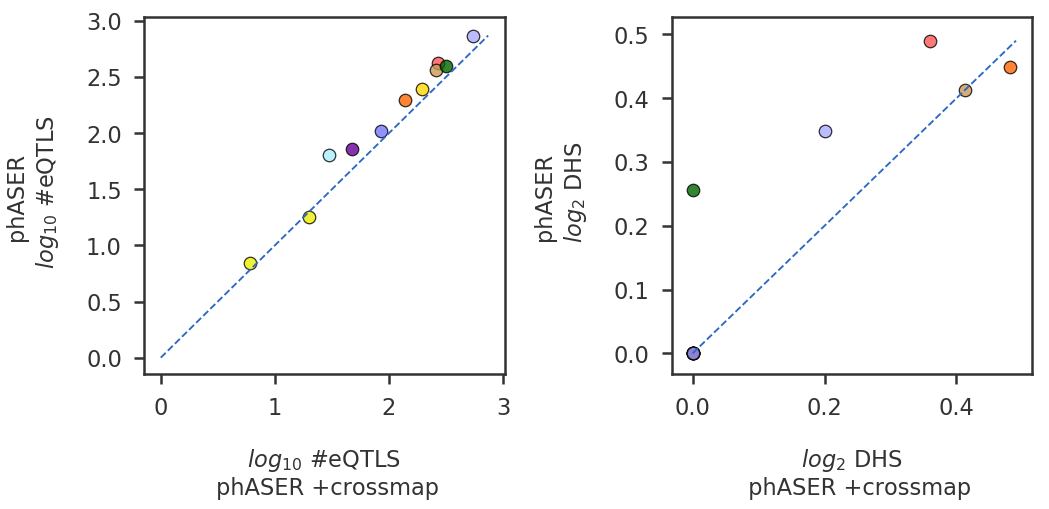

In [124]:
res1 = copy.copy(res_ph_cm)
res2 = copy.copy(res_ph)
neqtl1 = []
neqtl2 = []
ts_indata = list()
for ts in tshorts:
    if ts not in res1 and ts not in res2:
        print(f"{ts} not in dataset")
        continue
    else:
        neqtl1.append(np.log10(res1[ts].neqtl) if ts in res1 else 0)
        neqtl2.append(np.log10(res2[ts].neqtl) if ts in res2 else 0)
        ts_indata.append(ts)

enrich1 = []
enrich2 = []
ts_color = dict()
ed_color = dict()
ts_alpha = dict()
pval_c = 0.05
for ts in ts_indata:
    ts_color[ts] = tissue_colors[ts]
    ts_alpha[ts] = 0.9
    ed_color[ts] = "face"
    enrich1.append(res1[ts].enrichment if ts in res1 and res1[ts].pval < pval_c else 0)
    enrich2.append(res2[ts].enrichment if ts in res2 and res2[ts].pval < pval_c else 0)
    
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
for i, ts in enumerate(ts_indata):
    ax1.scatter(neqtl1[i], neqtl2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax1.plot([0,max(neqtl1+ neqtl2)],[0,max(neqtl1+ neqtl2)], linestyle="--")
ax1.set_xlabel("$log_{10}$ #eQTLS \n phASER +crossmap")
ax1.set_ylabel("phASER \n $log_{10}$ #eQTLS")


ax2 = fig.add_subplot(122)
for i, ts in enumerate(ts_indata):
    ax2.scatter(enrich1[i], enrich2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax2.plot([0,max(enrich1+enrich2)],[0,max(enrich1+enrich2)], linestyle="--")
ax2.set_xlabel("$log_2$ DHS \n  phASER +crossmap")
ax2.set_ylabel("phASER \n $log_2$ DHS")


plt.tight_layout()
plt.show()


wb not in dataset


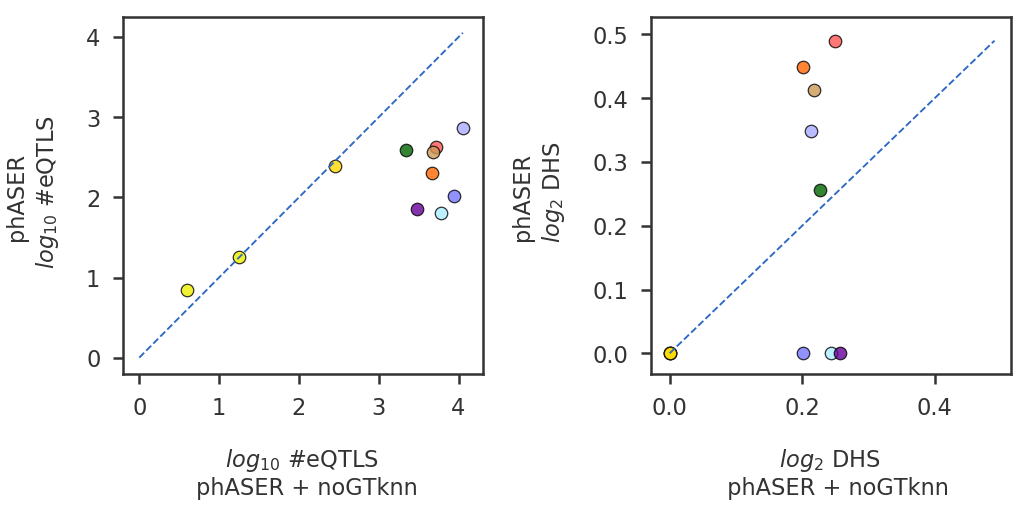

In [125]:
res1 = copy.copy(res_ph_nogtknn)
res2 = copy.copy(res_ph)
neqtl1 = []
neqtl2 = []
ts_indata = list()
for ts in tshorts:
    if ts not in res1 and ts not in res2:
        print(f"{ts} not in dataset")
        continue
    else:
        neqtl1.append(np.log10(res1[ts].neqtl) if ts in res1 else 0)
        neqtl2.append(np.log10(res2[ts].neqtl) if ts in res2 else 0)
        ts_indata.append(ts)

enrich1 = []
enrich2 = []
ts_color = dict()
ed_color = dict()
ts_alpha = dict()
pval_c = 0.05
for ts in ts_indata:
    ts_color[ts] = tissue_colors[ts]
    ts_alpha[ts] = 0.9
    ed_color[ts] = "face"
    enrich1.append(res1[ts].enrichment if ts in res1 and res1[ts].pval < pval_c else 0)
    enrich2.append(res2[ts].enrichment if ts in res2 and res2[ts].pval < pval_c else 0)
    
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
for i, ts in enumerate(ts_indata):
    ax1.scatter(neqtl1[i], neqtl2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax1.plot([0,max(neqtl1+ neqtl2)],[0,max(neqtl1+ neqtl2)], linestyle="--")
ax1.set_xlabel("$log_{10}$ #eQTLS \n phASER + noGTknn")
ax1.set_ylabel("phASER \n $log_{10}$ #eQTLS")


ax2 = fig.add_subplot(122)
for i, ts in enumerate(ts_indata):
    ax2.scatter(enrich1[i], enrich2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax2.plot([0,max(enrich1+enrich2)],[0,max(enrich1+enrich2)], linestyle="--")
ax2.set_xlabel("$log_2$ DHS \n  phASER + noGTknn")
ax2.set_ylabel("phASER \n $log_2$ DHS")


plt.tight_layout()
plt.show()


wb not in dataset


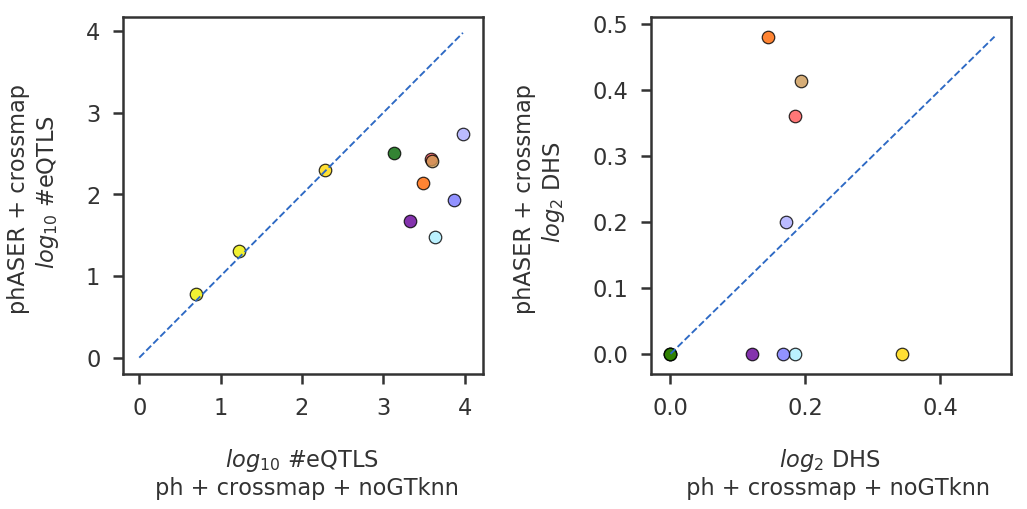

In [126]:
res1 = copy.copy(res_ph_cm_nogtknn)
res2 = copy.copy(res_ph_cm)
neqtl1 = []
neqtl2 = []
ts_indata = list()
for ts in tshorts:
    if ts not in res1 and ts not in res2:
        print(f"{ts} not in dataset")
        continue
    else:
        neqtl1.append(np.log10(res1[ts].neqtl) if ts in res1 else 0)
        neqtl2.append(np.log10(res2[ts].neqtl) if ts in res2 else 0)
        ts_indata.append(ts)

enrich1 = []
enrich2 = []
ts_color = dict()
ed_color = dict()
ts_alpha = dict()
pval_c = 0.05
for ts in ts_indata:
    ts_color[ts] = tissue_colors[ts]
    ts_alpha[ts] = 0.9
    ed_color[ts] = "face"
    enrich1.append(res1[ts].enrichment if ts in res1 and res1[ts].pval < pval_c else 0)
    enrich2.append(res2[ts].enrichment if ts in res2 and res2[ts].pval < pval_c else 0)
    
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
for i, ts in enumerate(ts_indata):
    ax1.scatter(neqtl1[i], neqtl2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax1.plot([0,max(neqtl1+ neqtl2)],[0,max(neqtl1+ neqtl2)], linestyle="--")
ax1.set_xlabel("$log_{10}$ #eQTLS \n ph + crossmap + noGTknn")
ax1.set_ylabel("phASER + crossmap \n $log_{10}$ #eQTLS")


ax2 = fig.add_subplot(122)
for i, ts in enumerate(ts_indata):
    ax2.scatter(enrich1[i], enrich2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax2.plot([0,max(enrich1+enrich2)],[0,max(enrich1+enrich2)], linestyle="--")
ax2.set_xlabel("$log_2$ DHS \n  ph + crossmap + noGTknn")
ax2.set_ylabel("phASER + crossmap \n $log_2$ DHS")

plt.tight_layout()
plt.show()



wb not in dataset


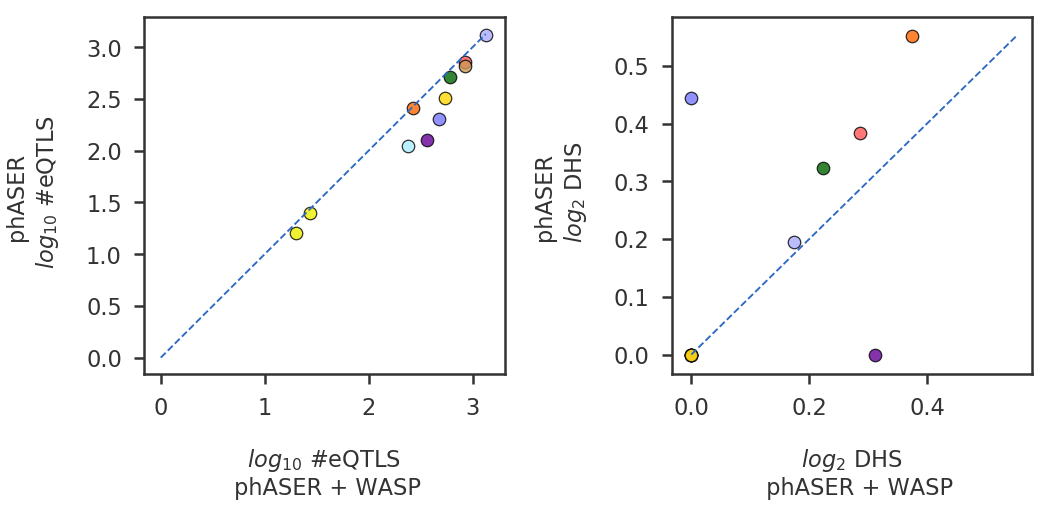

In [128]:
res1 = copy.copy(res_wasp)
res2 = copy.copy(res_sh2) #ph)
neqtl1 = []
neqtl2 = []
ts_indata = list()
for ts in tshorts:
    if ts not in res1 and ts not in res2:
        print(f"{ts} not in dataset")
        continue
    else:
        neqtl1.append(np.log10(res1[ts].neqtl) if ts in res1 else 0)
        neqtl2.append(np.log10(res2[ts].neqtl) if ts in res2 else 0)
        ts_indata.append(ts)

enrich1 = []
enrich2 = []
ts_color = dict()
ed_color = dict()
ts_alpha = dict()
pval_c = 0.05
for ts in ts_indata:
    ts_color[ts] = tissue_colors[ts]
    ts_alpha[ts] = 0.9
    ed_color[ts] = "face"
    enrich1.append(res1[ts].enrichment if ts in res1 and res1[ts].pval < pval_c else 0)
    enrich2.append(res2[ts].enrichment if ts in res2 and res2[ts].pval < pval_c else 0)
    
fig = plt.figure(figsize=(12,6))
ax1 = fig.add_subplot(121)
for i, ts in enumerate(ts_indata):
    ax1.scatter(neqtl1[i], neqtl2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax1.plot([0,max(neqtl1+ neqtl2)],[0,max(neqtl1+ neqtl2)], linestyle="--")
ax1.set_xlabel("$log_{10}$ #eQTLS \n phASER + WASP")
ax1.set_ylabel("phASER \n $log_{10}$ #eQTLS")


ax2 = fig.add_subplot(122)
for i, ts in enumerate(ts_indata):
    ax2.scatter(enrich1[i], enrich2[i], s=100, color=ts_color[ts], edgecolor = 'black', alpha = 0.8)
ax2.plot([0,max(enrich1+enrich2)],[0,max(enrich1+enrich2)], linestyle="--")
ax2.set_xlabel("$log_2$ DHS \n  phASER + WASP")
ax2.set_ylabel("phASER \n $log_2$ DHS")

plt.tight_layout()
plt.show()
